# DC Crime

### 06/24/2019

### Hiro Miyake

Washington, D.C. has an initiative to provide data to the public. This is at the link below.

http://opendata.dc.gov/

Furthermore, crime data is provided at a related website run by the Metropolitan Police Department.

https://dcatlas.dcgis.dc.gov/crimecards/

In this Python notebook, I explore the factors that are related to the type of crime occuring in DC. This could be used for predictive policing, or in other words, allow the Metropolitan Police Department to better allocate resources in anticipation of certain types of crimes occuring.

In [1]:
%matplotlib inline

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score

# Load the data

Crime data for the past 8 years (2011-2019) can be obtained at the website above, and whose link is given by

https://datagate.dc.gov/search/open/crimes?daterange=8years&details=true&format=csv

In [2]:
df = pd.read_csv('dc-crimes-search-results.csv')

In [3]:
df.head()

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,...,BLOCK,START_DATE,CCN,OFFENSE,OCTO_RECORD_ID,ANC,REPORT_DAT,METHOD,location,LATITUDE
0,cluster 20,9509.0,property,-76.993805,2014-08-20T12:30:00.000,burglary,day,142154.0,4.0,5.0,...,800 - 899 block of crittenden street ne,2014-08-20T12:00:00.000,14125714,burglary,14125714-01,5A,2014-08-20T16:46:00.000Z,others,"38.947289585934314,-76.993807538940317",38.947282
1,cluster 17,1901.0,property,-77.021173,2014-08-20T13:31:00.000,burglary,day,143865.0,4.0,4.0,...,500 - 699 block of peabody street nw,2014-08-20T13:25:00.000,14125736,burglary,14125736-01,4B,2014-08-20T18:02:00.000Z,others,"38.962700977587048,-77.021175136089184",38.962693
2,cluster 3,3400.0,property,-77.015705,2014-08-20T16:00:00.000,theft/other,evening,138583.0,3.0,1.0,...,1810 1899 block of 3rd street nw,2014-08-20T15:49:00.000,14125790,theft/other,14125790-01,1B,2014-08-20T23:20:00.000Z,others,"38.915120024258918,-77.015707015122302",38.915112
3,cluster 1,3800.0,property,-77.037860,2014-08-23T15:15:00.000,theft f/auto,evening,139649.0,3.0,1.0,...,mozart place nw and fuller street nw,2014-08-23T13:45:00.000,14127645,theft f/auto,14127645-01,1C,2014-08-23T19:18:00.000Z,others,"38.924717823327491,-77.037862469649198",38.924710
4,cluster 8,5800.0,violent,-77.020924,2014-08-23T15:06:00.000,robbery,evening,136884.0,1.0,2.0,...,600 - 699 block of h street nw,2014-08-23T15:00:00.000,14127654,robbery,14127654-01,2C,2014-08-23T19:14:00.000Z,gun,"38.899814022192331,-77.020925903391088",38.899806


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284626 entries, 0 to 284625
Data columns (total 29 columns):
NEIGHBORHOOD_CLUSTER    281119 non-null object
CENSUS_TRACT            283823 non-null float64
offensegroup            284626 non-null object
LONGITUDE               284626 non-null float64
END_DATE                271066 non-null object
offense-text            284626 non-null object
SHIFT                   284626 non-null object
YBLOCK                  284626 non-null float64
DISTRICT                284480 non-null float64
WARD                    284617 non-null float64
YEAR                    284626 non-null int64
offensekey              284626 non-null object
BID                     47743 non-null object
sector                  284475 non-null object
PSA                     284475 non-null float64
ucr-rank                284626 non-null int64
BLOCK_GROUP             283823 non-null object
VOTING_PRECINCT         284574 non-null object
XBLOCK                  284626 non-null 

In [5]:
df.describe()

,CENSUS_TRACT,LONGITUDE,YBLOCK,DISTRICT,WARD,YEAR,PSA,ucr-rank,XBLOCK,CCN,LATITUDE
count,283823.000000,284626.000000,284626.000000,284480.000000,284617.000000,284626.000000,284475.000000,284626.000000,284626.000000,2.846260e+05,284626.000000
mean,6219.703463,-77.008011,137641.393942,3.710415,4.425129,2014.887357,375.896160,5.977690,399305.774122,1.500524e+07,38.906625
std,3130.349468,0.036143,3416.839326,1.911850,2.351994,2.303112,190.899819,1.346734,3134.713335,2.323343e+06,0.030779
min,100.000000,-77.114142,127300.000000,1.000000,1.000000,2011.000000,101.000000,1.000000,390103.000000,1.020310e+06,38.813471
25%,3500.000000,-77.031958,136018.000000,2.000000,2.000000,2013.000000,207.000000,6.000000,397228.000000,1.309407e+07,38.892007
50%,7000.000000,-77.012930,137621.000000,3.000000,5.000000,2015.000000,308.000000,6.000000,398878.000000,1.508299e+07,38.906444
75%,8904.000000,-76.985513,139683.000000,5.000000,6.000000,2017.000000,507.000000,7.000000,401257.000000,1.707044e+07,38.925020
max,11100.000000,-76.910021,147441.000000,7.000000,8.000000,2019.000000,708.000000,9.000000,407806.000000,9.925858e+07,38.994901


In [6]:
df.shape

(284626, 29)

# Initial exploratory data analysis

## Output variable

In [7]:
df.OFFENSE.value_counts()

theft/other                   109217
theft f/auto                   86910
robbery                        25252
motor vehicle theft            21891
burglary                       20452
assault w/dangerous weapon     17416
sex abuse                       2330
homicide                         999
arson                            159
Name: OFFENSE, dtype: int64

There are 9 offense types.

In [8]:
df['offense-text'].value_counts()

theft/other                   109217
theft f/auto                   86910
robbery                        25252
motor vehicle theft            21891
burglary                       20452
assault w/dangerous weapon     17416
sex abuse                       2330
homicide                         999
arson                            159
Name: offense-text, dtype: int64

In [9]:
df.OFFENSE.equals(df['offense-text'])

True

`OFFENSE` and `offense-text` contain exactly the same information. We can drop `offense-text`.

Check how many null values there are.

In [10]:
df.isnull().sum()

NEIGHBORHOOD_CLUSTER      3507
CENSUS_TRACT               803
offensegroup                 0
LONGITUDE                    0
END_DATE                 13560
offense-text                 0
SHIFT                        0
YBLOCK                       0
DISTRICT                   146
WARD                         9
YEAR                         0
offensekey                   0
BID                     236883
sector                     151
PSA                        151
ucr-rank                     0
BLOCK_GROUP                803
VOTING_PRECINCT             52
XBLOCK                       0
BLOCK                        1
START_DATE                   5
CCN                          0
OFFENSE                      0
OCTO_RECORD_ID               0
ANC                          0
REPORT_DAT                   0
METHOD                       0
location                     0
LATITUDE                     0
dtype: int64

There are a number of columns with null values.

## Features

Let's look at each feature to understand their properties.

In [11]:
df['NEIGHBORHOOD_CLUSTER'].value_counts(dropna=False)

cluster 2     22951
cluster 8     19751
cluster 25    16086
cluster 6     15170
cluster 26    13326
cluster 18    12653
cluster 3     12530
cluster 39    11423
cluster 23    10923
cluster 21    10389
cluster 7     10024
cluster 22     9846
cluster 4      8335
cluster 17     8037
cluster 33     7806
cluster 31     7666
cluster 34     7116
cluster 32     7079
cluster 1      6924
cluster 38     5091
cluster 9      4945
cluster 11     4869
cluster 5      4643
cluster 30     3963
cluster 24     3954
cluster 19     3851
cluster 37     3808
NaN            3507
cluster 20     3422
cluster 28     3418
cluster 15     3051
cluster 35     2923
cluster 36     2884
cluster 10     2368
cluster 14     2223
cluster 27     2004
cluster 13     1719
cluster 12     1616
cluster 16     1535
cluster 29      797
Name: NEIGHBORHOOD_CLUSTER, dtype: int64

There are many clusters, some of them NaN.

In [12]:
df['CENSUS_TRACT'].value_counts(dropna=False)

5800.0     9164
4400.0     6999
10700.0    6329
10600.0    5271
11100.0    4728
202.0      4353
3000.0     4215
9102.0     4136
5500.0     3911
10100.0    3634
5201.0     3522
100.0      3393
9603.0     3388
8803.0     3230
1001.0     3100
2502.0     2934
3100.0     2893
3500.0     2849
2802.0     2673
7601.0     2629
10400.0    2614
7000.0     2525
4300.0     2414
8802.0     2394
1804.0     2381
7803.0     2322
7603.0     2295
7200.0     2261
10200.0    2202
3400.0     2201
           ... 
10500.0     713
9906.0      707
11000.0     700
1302.0      683
1803.0      680
6802.0      680
9302.0      674
901.0       667
1500.0      663
2301.0      640
9801.0      636
9203.0      631
2001.0      619
502.0       614
2302.0      564
1002.0      534
9509.0      529
1401.0      441
1402.0      429
400.0       422
701.0       413
9802.0      363
802.0       324
6804.0      322
201.0       306
902.0       298
9507.0      279
1301.0      252
702.0       245
7301.0       22
Name: CENSUS_TRACT, Leng

These are probably defined by the US Census Bureau, indicating some geographic area. Probably not appropriate to treat the numerical values as is.

In [13]:
df.offensegroup.value_counts(dropna=False)

property    238629
violent      45997
Name: offensegroup, dtype: int64

There are only two types of offense groups.

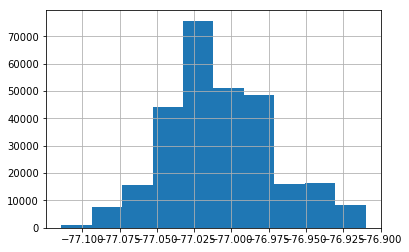

In [14]:
df.LONGITUDE.hist()

`LONGITUDE` is self-explanatory.

In [15]:
df['END_DATE'][0]

'2014-08-20T12:30:00.000'

`END_DATE` is in string format. But there are a few rows with NaNs. It's not clear what this means, possibly when the case is closed.

In [16]:
df.SHIFT.value_counts(dropna=False)

evening     121470
day         108128
midnight     55028
Name: SHIFT, dtype: int64

There are three shifts. There aren't so many crimes at midnight. Presumably the day is earliest, then evening, then midnight. This should be captured in `START_DATE`.

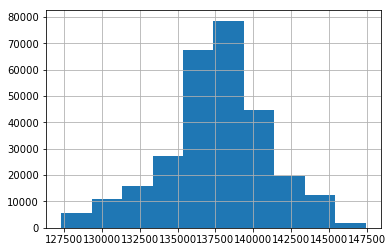

In [17]:
df['YBLOCK'].hist()

It's not clear exactly what this number is, but probably related to the location of the crime.

In [18]:
df['DISTRICT'].value_counts(dropna=False)

 3.0    52453
 2.0    50264
 1.0    41702
 5.0    38362
 6.0    37773
 4.0    36660
 7.0    27266
NaN       146
Name: DISTRICT, dtype: int64

There are 7 districts.

In [19]:
df['WARD'].value_counts(dropna=False)

 2.0    51916
 6.0    46083
 1.0    40612
 5.0    39327
 7.0    35237
 8.0    31070
 4.0    25555
 3.0    14817
NaN         9
Name: WARD, dtype: int64

There are 8 wards.

Districts are related to policing (https://mpdc.dc.gov/page/police-districts-and-police-service-areas).  
Wards are for more general governance (https://planning.dc.gov/page/neighborhood-planning-01).

Pictorially the differences can be seen clearly (images from the links above).

![title](wards_small.png)
![title](districts_small.jpg)

In [20]:
df.YEAR.value_counts(dropna=False)

2014    38401
2015    37299
2016    37199
2013    35867
2012    35283
2018    33644
2017    33082
2011    19472
2019    14379
Name: YEAR, dtype: int64

Dataset contains data from 2011 to 2019. To avoid edge effects, should really only use data between 2012 and 2018 inclusive.

In [21]:
df.offensekey.value_counts(dropna=False)

property|theft/other                  109217
property|theft f/auto                  86910
violent|robbery                        25252
property|motor vehicle theft           21891
property|burglary                      20452
violent|assault w/dangerous weapon     17416
violent|sex abuse                       2330
violent|homicide                         999
property|arson                           159
Name: offensekey, dtype: int64

This appears to be just a concatenation of features `OFFENSE` and `offensegroup`.

In [22]:
df.BID.value_counts(dropna=False)

NaN                          236883
downtown                      16364
golden triangle                5632
georgetown                     5216
capitol hill                   4722
noma                           4310
southwest                      3240
adams morgan                   2528
capitol riverfront             2194
mount vernon triangle cid      1984
anacostia                      1454
dupont circle                    99
Name: BID, dtype: int64

These are names of certain geographical areas. Clearly many have no labels.

In [23]:
df.sector.value_counts(dropna=False)

2D3    26064
3D2    19173
3D3    17750
1D2    17140
3D1    15558
5D2    15263
2D2    14082
1D1    13774
6D1    13721
4D1    13000
6D3    12852
5D3    12526
4D3    12335
4D2    11322
6D2    11197
1D3    10676
5D1    10602
7D1    10170
2D1    10144
7D2     9872
7D3     7254
NaN      151
Name: sector, dtype: int64

Sectors are subdivisions of districts. (https://mpdc.dc.gov/page/police-districts-and-police-service-areas)

In [24]:
df.PSA.value_counts(dropna=False)

 207.0    10402
 208.0    10101
 302.0     9988
 305.0     8717
 206.0     8372
 106.0     7655
 602.0     6940
 603.0     6911
 307.0     6704
 101.0     6630
 104.0     6630
 507.0     6397
 503.0     6240
 506.0     6129
 308.0     6111
 107.0     6018
 303.0     6010
 604.0     5941
 304.0     5570
 209.0     5561
 501.0     5448
 505.0     5266
 502.0     5154
 404.0     5039
 301.0     5036
 202.0     4895
 402.0     4815
 607.0     4717
 608.0     4713
 102.0     4663
 108.0     4492
 306.0     4345
 409.0     4203
 401.0     4102
 403.0     4083
 405.0     4028
 704.0     4018
 703.0     4009
 708.0     3968
 204.0     3885
 504.0     3757
 407.0     3729
 406.0     3565
 605.0     3467
 707.0     3301
 706.0     3286
 701.0     3168
 408.0     3093
 105.0     3021
 606.0     3013
 702.0     2993
 203.0     2975
 705.0     2553
 103.0     2481
 201.0     2274
 601.0     2068
 205.0     1825
NaN         151
Name: PSA, dtype: int64

PSA (Police Service Area) are subdivisions of sectors.

In [25]:
df['ucr-rank'].value_counts()

6    109217
7     86910
4     25252
8     21891
5     20452
3     17416
2      2330
1       999
9       159
Name: ucr-rank, dtype: int64

It looks like this is a numerical encoding of the offense, since the values are exactly the same.

In [26]:
print(df['BLOCK_GROUP'])[0]
df['BLOCK_GROUP'].value_counts()

009509 2


005800 1    7653
004400 2    4757
010600 2    4365
010700 1    4202
003000 1    3404
009102 2    3271
008803 1    3230
003100 1    2893
010100 1    2514
000100 4    2489
000202 4    2261
004400 1    2242
004702 1    2173
011100 1    2127
010700 2    2127
004801 1    2009
008302 1    1829
003400 2    1809
005900 1    1799
001804 2    1789
007000 2    1768
003500 2    1765
009603 2    1758
011100 3    1715
005500 1    1650
007200 2    1641
006202 1    1618
010200 2    1560
007504 1    1535
007100 2    1529
            ... 
003900 4     141
007703 4     140
001402 3     139
004001 2     139
001001 5     138
001402 2     131
001500 5     124
009509 1     124
002102 5     123
000702 1     120
002701 1     119
000802 2     109
001301 2      92
000801 2      90
001301 1      81
009602 2      81
000902 1      80
001301 3      79
000300 2      74
000702 3      71
001500 3      68
011000 1      65
000701 3      57
000702 2      54
000701 2      50
009802 1      48
001302 1      46
000801 1      

It's not clear what this is.

In [27]:
df['VOTING_PRECINCT'].value_counts()

precinct 129    13063
precinct 17      8715
precinct 83      6533
precinct 72      6270
precinct 39      5705
precinct 22      5279
precinct 6       4950
precinct 37      4805
precinct 16      4333
precinct 1       4233
precinct 14      4091
precinct 91      3837
precinct 76      3756
precinct 18      3692
precinct 102     3425
precinct 5       3399
precinct 81      3399
precinct 114     3377
precinct 19      3294
precinct 36      3250
precinct 125     3090
precinct 137     3014
precinct 82      2974
precinct 74      2695
precinct 89      2685
precinct 25      2652
precinct 119     2579
precinct 31      2570
precinct 90      2558
precinct 116     2486
                ...  
precinct 70      1052
precinct 64      1021
precinct 88      1012
precinct 49       995
precinct 13       982
precinct 133      940
precinct 3        898
precinct 55       883
precinct 45       756
precinct 20       755
precinct 8        719
precinct 58       694
precinct 30       677
precinct 51       676
precinct 1

Self explanatory, probably.

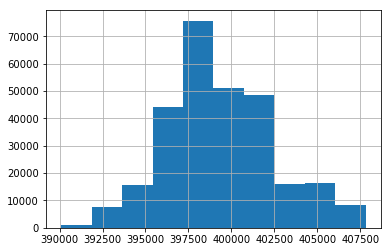

In [28]:
df['XBLOCK'].hist()

Not sure exactly what this is, but most likely related to `YBLOCK`.

In [29]:
df.BLOCK[:5]

0    800 - 899 block of crittenden street ne
1      500  - 699 block of peabody street nw
2          1810 1899  block of 3rd street nw
3       mozart place nw and fuller street nw
4             600 - 699 block of h street nw
Name: BLOCK, dtype: object

This seems to be the actual street name of where the crime took place.

In [30]:
df.BLOCK.unique().shape

(14954,)

There's a lot of unique block names, as expected.

In [31]:
df['START_DATE'][0]

'2014-08-20T12:00:00.000'

This is the start date of the crime in string format. We should turn this into a datetime Python object.

In [32]:
df.CCN.unique().shape

(284549,)

In [33]:
df.shape

(284626, 29)

There are about as many unique `CCN` values as there are number of rows. Maybe it's like a crime ID.

In [34]:
len(df.OCTO_RECORD_ID.unique()) == df.shape[0]

True

It's likely that `OCTO_RECORD_ID` is a unique identifier for each crime.

In [35]:
df.ANC.value_counts()

1B    16852
2B    15343
1A    14851
2C    12158
6B    11915
5C    11378
6C     9926
5E     9771
2F     9696
5D     9579
6A     8998
6E     8627
2E     8348
4C     8024
7C     7644
7F     7465
7D     7045
4B     7007
8A     6903
8C     6890
7B     6858
6D     6767
8B     6314
7E     6249
1C     6200
4A     6100
8E     5652
2A     5398
8D     5302
5B     5075
3E     4629
3C     3681
5A     3393
4D     3377
1D     2632
3G     2259
3F     2039
3D     1981
3B     1254
2D     1046
Name: ANC, dtype: int64

This is the Advisory Neighborhood Commission (ANC) (https://anc.dc.gov/page/about-ancs). This is related to the location.

In [36]:
df.REPORT_DAT[0]

'2014-08-20T16:46:00.000Z'

I guess this is the date reported. Is this different from `START_DATE`?

In [37]:
df.START_DATE[0]

'2014-08-20T12:00:00.000'

The time is a little different.

In [38]:
df.METHOD.value_counts()

others    260375
gun        15652
knife       8599
Name: METHOD, dtype: int64

I guess this is the tool used to commit the crime.

In [39]:
df.location[:5]

0    38.947289585934314,-76.993807538940317
1    38.962700977587048,-77.021175136089184
2    38.915120024258918,-77.015707015122302
3    38.924717823327491,-77.037862469649198
4    38.899814022192331,-77.020925903391088
Name: location, dtype: object

These appear to by (latitude, longitude) pairs in string format.

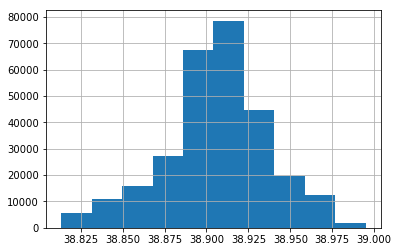

In [40]:
df.LATITUDE.hist()

`LATITUDE` is self explanatory.

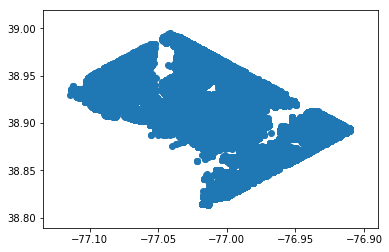

In [41]:
plt.scatter(df.LONGITUDE, df.LATITUDE)

Generally it appears there is crime everywhere in DC except at rivers. Or maybe natural areas are a different jurisdiction.

# Preprocessing and feature selection

Now that we have an idea of what the features we can work with are, let's choose a subset of meaningful ones that we can work with to build a model.

Qualitatively, let's keep the following types of variables.

1. Offense type
2. Time it happened
3. Where it happened

Note that there are many ways geographic information is provided in the data, e.g., `NEIGHBHORHOOD_CLUSTER`, `DISTRICT`, `WARD`, `ANC`. We should pick one, since choosing multiple will lead to co-linear features. It should not be too fine-grained as that can cause overfitting. Since this is a policing data set, it makes sense to use a geographic division consistent with the local police areas. This means I should use `DISTRICT` as my unit of location.

1. `offensegroup`
2. `START_DATE`
3. `DISTRICT`
4. `YEAR`

In [42]:
crime = df[['offensegroup','START_DATE','DISTRICT','YEAR']]
crime.head()

,offensegroup,START_DATE,DISTRICT,YEAR
0,property,2014-08-20T12:00:00.000,4.0,2014
1,property,2014-08-20T13:25:00.000,4.0,2014
2,property,2014-08-20T15:49:00.000,3.0,2014
3,property,2014-08-23T13:45:00.000,3.0,2014
4,violent,2014-08-23T15:00:00.000,1.0,2014


To avoid edge effects and to have the full data for each year, I subset on `YEAR` between 2012 and 2018.

In [43]:
crime = crime[(crime.YEAR > 2011) & (crime.YEAR < 2019)]
crime.describe()

,DISTRICT,YEAR
count,250642.000000,250775.000000
mean,3.716711,2014.953388
std,1.911543,1.967940
min,1.000000,2012.000000
25%,2.000000,2013.000000
50%,3.000000,2015.000000
75%,5.000000,2017.000000
max,7.000000,2018.000000


We see that the minimum year is now 2012 and maximum year is now 2018.

In [44]:
crime.isnull().sum()

offensegroup      0
START_DATE        4
DISTRICT        133
YEAR              0
dtype: int64

In [45]:
crime.shape

(250775, 4)

There are a few crimes where the start date and/or district is not known. These are relatively few out of the 250775 rows, so I will just drop rows with any null values.

In [46]:
crime = crime.dropna(axis=0)
crime.shape

(250638, 4)

In [47]:
crime.head()

,offensegroup,START_DATE,DISTRICT,YEAR
0,property,2014-08-20T12:00:00.000,4.0,2014
1,property,2014-08-20T13:25:00.000,4.0,2014
2,property,2014-08-20T15:49:00.000,3.0,2014
3,property,2014-08-23T13:45:00.000,3.0,2014
4,violent,2014-08-23T15:00:00.000,1.0,2014


In [48]:
crime.offensegroup.value_counts(dropna=False)

property    210282
violent      40356
Name: offensegroup, dtype: int64

We see that out of about 250K crimes, 16% are violent crimes and 84% are property crimes. This is somewhat imbalanced for the purposes of model building, but it is not too extreme.

Let's now convert `START_DATE` into a datetime object and extract some date and time information suitable for machine learning.

In [49]:
crime.START_DATE = crime.START_DATE.map(lambda x: datetime.strptime(x.replace('T',' '), '%Y-%m-%d %H:%M:%S.%f'))
crime.START_DATE[:5]

0   2014-08-20 12:00:00
1   2014-08-20 13:25:00
2   2014-08-20 15:49:00
3   2014-08-23 13:45:00
4   2014-08-23 15:00:00
Name: START_DATE, dtype: datetime64[ns]

From the datetime, get the weekday. 0 is Monday and 6 is Sunday.

https://docs.python.org/2/library/datetime.html

In [50]:
crime['weekday'] = crime.START_DATE.map(lambda x: x.weekday())
crime.weekday[:5]

0    2
1    2
2    2
3    5
4    5
Name: weekday, dtype: int64

Get the month.

In [51]:
crime['month'] = crime.START_DATE.map(lambda x: x.month)
crime.month[:5]

0    8
1    8
2    8
3    8
4    8
Name: month, dtype: int64

Get the hour.

In [52]:
crime['hour'] = crime.START_DATE.map(lambda x: x.hour)
crime.hour[:5]

0    12
1    13
2    15
3    13
4    15
Name: hour, dtype: int64

In [53]:
crime.head()

,offensegroup,START_DATE,DISTRICT,YEAR,weekday,month,hour
0,property,2014-08-20 12:00:00,4.0,2014,2,8,12
1,property,2014-08-20 13:25:00,4.0,2014,2,8,13
2,property,2014-08-20 15:49:00,3.0,2014,2,8,15
3,property,2014-08-23 13:45:00,3.0,2014,5,8,13
4,violent,2014-08-23 15:00:00,1.0,2014,5,8,15


Let's recode the `offensegroup` so that `violent` is 1 and `property` is 0.

In [54]:
crime['y'] = (crime.offensegroup == 'violent')*1
crime.head()

,offensegroup,START_DATE,DISTRICT,YEAR,weekday,month,hour,y
0,property,2014-08-20 12:00:00,4.0,2014,2,8,12,0
1,property,2014-08-20 13:25:00,4.0,2014,2,8,13,0
2,property,2014-08-20 15:49:00,3.0,2014,2,8,15,0
3,property,2014-08-23 13:45:00,3.0,2014,5,8,13,0
4,violent,2014-08-23 15:00:00,1.0,2014,5,8,15,1


In [55]:
modeling = crime[['YEAR','weekday','month','hour','DISTRICT','y']]
modeling.head()

,YEAR,weekday,month,hour,DISTRICT,y
0,2014,2,8,12,4.0,0
1,2014,2,8,13,4.0,0
2,2014,2,8,15,3.0,0
3,2014,5,8,13,3.0,0
4,2014,5,8,15,1.0,1


# Model training

For interpretability purposes, I use a logistic regression to determine the factors related to the type of crime (property or violent).

In [56]:
train = modeling[modeling.YEAR != 2018]
test = modeling[modeling.YEAR == 2018]
print(train.shape)
print(test.shape)

(216999, 6)
(33639, 6)


In [57]:
formula = 'y ~ C(weekday) + C(month) + C(hour) + C(DISTRICT)'

In [58]:
results = smf.logit(formula, data=train).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.410816
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               216999
Model:                          Logit   Df Residuals:                   216952
Method:                           MLE   Df Model:                           46
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:                 0.08928
Time:                        11:09:44   Log-Likelihood:                -89147.
converged:                       True   LL-Null:                       -97886.
                                        LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.3191      0.040    -33.141      0.000      -1.397      -1.241
C(weekday)[T.1L]       0.0110      0.023      0.476      0.634      -0.034       0.056
C(weekday)[T.2L]       0.0178      0.023      0.770      0.441      -0.027       0.063
C(weekday)[T.3L]      -0.0290      0.023     -1.247      0.212      -0.075       0.017
C(weekday)[T.4L]      -0.0780      0.023     -3.435      0.001      -0.122      -0.033
C(weekday)[T.5L]       0.0236      0.022      1.061      0.289      -0.020       0.067
C(weekday)[T.6L]       0.0855      0.023      3.783      0.000       0.041       0.130
C(month)[T.2L]        -0.0515      0.032     -1.621      0.105      -0.114       0.011
C(month)[T.3L]        -0.1150      0.031     -3.722      0.000      -0.176      -0.054
C(month)[T.4L]        -0.0725      0.030     -2.425      0.015      -0.131      -0.014
C(month)[T.5L]        -0.1540      0.029     -5.270      0.000      -0.211      -0.097
C(month)[T.6L]        -0.1402      0.029     -4.821      0.000      -0.197      -0.083
C(month)[T.7L]        -0.1488      0.029     -5.174      0.000      -0.205      -0.092
C(month)[T.8L]        -0.1612      0.029     -5.592      0.000      -0.218      -0.105
C(month)[T.9L]        -0.1469      0.029     -5.056      0.000      -0.204      -0.090
C(month)[T.10L]       -0.1045      0.029     -3.653      0.000      -0.161      -0.048
C(month)[T.11L]       -0.1815      0.030     -6.070      0.000      -0.240      -0.123
C(month)[T.12L]       -0.1590      0.030     -5.356      0.000      -0.217      -0.101
C(hour)[T.1L]          0.2994      0.038      7.900      0.000       0.225       0.374
C(hour)[T.2L]          0.5539      0.039     14.085      0.000       0.477       0.631
C(hour)[T.3L]          0.5905      0.042     14.077      0.000       0.508       0.673
C(hour)[T.4L]          0.2891      0.049      5.950      0.000       0.194       0.384
C(hour)[T.5L]         -0.1032      0.053     -1.931      0.053      -0.208       0.002
C(hour)[T.6L]         -0.7102      0.055    -12.902      0.000      -0.818      -0.602
C(hour)[T.7L]         -1.1778      0.053    -22.194      0.000      -1.282      -1.074
C(hour)[T.8L]         -1.2482      0.046    -26.851      0.000      -1.339      -1.157
C(hour)[T.9L]         -1.1944      0.045    -26.668      0.000      -1.282      -1.107
C(hour)[T.10L]        -1.1065      0.044    -25.382      0.000      -1.192      -1.021
C(hour)[T.11L]        -1.0295      0.042    -24.473      0.000      -1.112      -0.947
C(hour)[T.12L]        -1.0961      0.040    -27.068      0.000      -1.176      -1.017
C(hour)[T.13L]        -0.9097      0.040    -22.664      0.000      -0.988      -0.831
C(hour)[T.14L]        -0.8559      0.039    -22.002      0.000      -0.932      -0.780
C(hour)[T.15L]        -0.7541      0.037    -20.118      0.000      -0.828      -0.681
C(hour)[T.16L]        -0.7139      0.037    -19.074      0.000      -0.787      -0.641
C(hour)[T.17L]        

In [59]:
pred = results.predict(test)
score = roc_auc_score(test['y'], pred)
print 'Area under the ROC curve: ' + str(score)

Area under the ROC curve: 0.7270171879357404


An AUC above 0.5 means the model has predictive power.

I use the method of the Bonferroni correction to determine the factors which are correlated with the outcome in a statistically significant way despite the numerous factors being considered.

In [60]:
params = pd.DataFrame([results.params, results.pvalues], index = ['params','pvalues'])
params = params.transpose()
params[params.pvalues < 0.05/(6+11+23+6)].sort_values(by = ['params'])

,params,pvalues
Intercept,-1.319056,7.604109e-241
C(hour)[T.8L],-1.248178,8.210587e-159
C(hour)[T.9L],-1.194361,1.107656e-156
C(hour)[T.7L],-1.177752,3.911336e-109
C(hour)[T.10L],-1.106535,3.988430e-142
C(hour)[T.12L],-1.096135,2.340052e-161
C(hour)[T.11L],-1.029470,2.862272e-132
C(hour)[T.13L],-0.909655,1.017057e-113
C(hour)[T.14L],-0.855851,2.748108e-107
C(DISTRICT)[T.2.0],-0.763581,2.880938e-164


Generally, morning and daytime hours have low violent crime rates, as well as District 2. Very early hours, between 1 and 4 am tend to be related to more violent crimes, and Districts 6 and 7 tend to have relatively higher number of violent crimes.

# Conclusions

If you want to prevent violent crimes, the Metropolitan Police Department may want to increase officers in the very early hours of the day, around 1-4am, as well as in Districts 4, 5, 6, and 7. The month does not affect the nature of the crime very much.